# recreate a coadd

Get all the images that went into a coadd, and then rebuild it.

Maybe tweak some of the image combination parameters for fun, or just rebuild for a few months of observations.

## set up

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time

import pandas
pandas.set_option('display.max_rows', 1000)

import lsst.daf.butler as dafButler

import lsst.geom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

## choose DP0.2 collection

Collection chosen to use same image as in NB 01, the pretty cluster

In [2]:
repo = 's3://butler-us-central1-panda-dev/dc2/butler-external.yaml'
collection = '2.2i/runs/DP0.2/v23_0_1_rc1/PREOPS-905/pilot_tract4431'

butler = dafButler.Butler(repo, collections=collection)

## choose a coadd

same as we use for NB 01

In [3]:
my_spherePoint = lsst.geom.SpherePoint(55.745834*lsst.geom.degrees,
                                       -32.269167*lsst.geom.degrees)
print(my_spherePoint)

skymap = butler.get('skyMap')
my_tract = skymap.findTract(my_spherePoint)
my_patch = my_tract.findPatch(my_spherePoint)
my_patch_id = my_tract.getSequentialPatchIndex(my_patch)
print('my_tract = ', my_tract)
print('my_patch = ', my_patch)
print('my_patch_id = ', my_patch_id)

dataId = {'band': 'i', 'tract': 4431, 'patch': 17}
deepCoadd = butler.get('deepCoadd', dataId=dataId)

(55.7458340000, -32.2691670000)
my_tract =  TractInfo(id=4431)
my_patch =  PatchInfo(index=Index2D(x=3, y=2))
my_patch_id =  17


show the coadd

In [4]:
# fig = plt.figure(figsize=(6, 4))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(deepCoadd.image)
# plt.gca().axis('off')

get more info about the pixel data (for scaling when using imshow)

In [5]:
imgdata = np.asarray( deepCoadd.image.array, dtype='float' )
print( np.min(imgdata), np.mean(imgdata), np.max(imgdata) )
del imgdata

-0.32105696201324463 0.1392329267664109 1380.316162109375


get more information about the bounding box and wcs

In [6]:
deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=dataId)
print( deepCoadd_bbox.beginX, deepCoadd_bbox.beginY, deepCoadd_bbox.endX, deepCoadd_bbox.endY )
print( deepCoadd_bbox.minX, deepCoadd_bbox.minY, deepCoadd_bbox.maxX, deepCoadd_bbox.maxY )
print( deepCoadd_bbox.getCorners )
print(' ')

deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=dataId)
print( deepCoadd_wcs )

deepCoadd_fitsMd = WCS(deepCoadd_wcs.getFitsMetadata())
print( deepCoadd_fitsMd )

del deepCoadd_bbox, deepCoadd_wcs, deepCoadd_fitsMd

11900 7900 16100 12100
11900 7900 16099 12099
<bound method PyCapsule.getCorners of Box2I(corner=Point2I(11900, 7900), dimensions=Extent2I(4200, 4200))>
 
FITS standard SkyWcs:
Sky Origin: (55.6521739130, -31.9834710744)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 55.65217391304347  -31.98347107438015  
CRPIX : 14000.0  14000.0  
CD1_1 CD1_2  : -5.5555555555555e-05  0.0  
CD2_1 CD2_2  : 0.0  5.55555555555559e-05  
NAXIS : 0  0


## identify coadd inputs

In [7]:
coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", dataId)

In [8]:
coadd_inputs_ccds_table = coadd_inputs.ccds.asAstropy()

In [9]:
coadd_inputs_ccds_table

id,bbox_min_x,bbox_min_y,bbox_max_x,bbox_max_y,ccd,visit,goodpix,weight,filter
,pix,pix,pix,pix,,,,,
int64,int32,int32,int32,int32,int32,int64,int32,float64,str32
227922000,0,0,4071,3999,0,227922,1512880,1.745271720648272,i_sim_1.4
951274001,0,0,4071,3999,1,951274,1577144,4.326007963992991,i_sim_1.4
951274002,0,0,4071,3999,2,951274,154692,4.326007963992991,i_sim_1.4
951274004,0,0,4071,3999,4,951274,10850788,4.326007963992991,i_sim_1.4
951274005,0,0,4071,3999,5,951274,3615362,4.326007963992991,i_sim_1.4
951274007,0,0,4071,3999,7,951274,3671,4.326007963992991,i_sim_1.4
420782005,0,0,4071,3999,5,420782,9876512,4.539556638143641,i_sim_1.4
420782008,0,0,4071,3999,8,420782,828705,4.539556638143641,i_sim_1.4


In [10]:
# coadd_inputs_visits_table = coadd_inputs.visits.asAstropy()

In [11]:
# coadd_inputs_visits_table

## retrieve just one of the calexps which contributed

In [12]:
use_detector = coadd_inputs_ccds_table['ccd'][0]
use_visit = coadd_inputs_ccds_table['visit'][0]

print('ccd, visit = ', use_detector, use_visit)
calexp = butler.get('calexp', detector=use_detector, visit=use_visit)

ccd, visit =  0 227922


In [13]:
# fig = plt.figure(figsize=(6, 4))
# afw_display = afwDisplay.Display(1)
# afw_display.scale('asinh', 'zscale')
# afw_display.mtv(calexp.image)
# plt.gca().axis('off')

In [14]:
imgdata = np.asarray( calexp.image.array, dtype='float' )
print( np.min(imgdata), np.mean(imgdata), np.max(imgdata) )
del imgdata

-380.42010498046875 6.565610028781216 130776.6640625


In [15]:
calexp_bbox = butler.get('calexp.bbox', detector=use_detector, visit=use_visit)
print( calexp_bbox.beginX, calexp_bbox.beginY, calexp_bbox.endX, calexp_bbox.endY )
print( calexp_bbox.minX, calexp_bbox.minY, calexp_bbox.maxX, calexp_bbox.maxY )
print( calexp_bbox.getCorners )
print(' ')

calexp_wcs = butler.get('calexp.wcs', detector=use_detector, visit=use_visit)
print( calexp_wcs )

calexp_fitsMd = WCS(calexp_wcs.getFitsMetadata())
print( calexp_fitsMd )

del calexp_bbox, calexp_wcs, calexp_fitsMd

0 0 4072 4000
0 0 4071 3999
<bound method PyCapsule.getCorners of Box2I(corner=Point2I(0, 0), dimensions=Extent2I(4072, 4000))>
 
FITS standard SkyWcs:
Sky Origin: (55.4083624749, -32.2081704959)
Pixel Origin: (1999.04, 2004.19)
Pixel Scale: 0.199507 arcsec/pixel
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 55.40836247491401  -32.20817049585821  
CRPIX : 2000.039674  2005.188075  
CD1_1 CD1_2  : -5.5439216602696e-05  1.40560222076641e-06  
CD2_1 CD2_2  : 1.28558780423678e-06  5.53652422220074e-05  
NAXIS : 0  0


In [16]:
del use_detector, use_visit

### do the coadd and the calexp look like they overlap?

`projection = WCS()` DOES NOT WORK FOR COADDS, ORIGIN NOT RECOGNIZED, WORKING ON A FIX

In [17]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=False, sharey=False)

# plt.subplot(1, 2, 1, projection=WCS(deepCoadd.getWcs().getFitsMetadata()))
# plt.imshow(deepCoadd.image.array, cmap='gray', vmin=0, vmax=2, origin='lower')
# plt.grid(color='white', ls='solid')
# plt.xlabel('Right Ascension')
# plt.ylabel('Declination')

# plt.subplot(1, 2, 2,  projection=WCS(calexp.getWcs().getFitsMetadata()))
# plt.imshow(calexp.image.array, cmap='gray', vmin=-10, vmax=100, origin='lower')
# plt.grid(color='white', ls='solid')
# plt.xlabel('Right Ascension')
# plt.ylabel('Declination')

# plt.show()

In [18]:
del calexp, deepCoadd

## get corners for the coadd and all input calexps

get corners for the coadd

In [19]:
deepCoadd_bbox = butler.get('deepCoadd.bbox', dataId=dataId)
deepCoadd_wcs = butler.get('deepCoadd.wcs', dataId=dataId)

X0 = deepCoadd_bbox.beginX
Y0 = deepCoadd_bbox.beginY
X1 = deepCoadd_bbox.endX
Y1 = deepCoadd_bbox.endY
corners = [ deepCoadd_wcs.pixelToSky(X0, Y0), 
            deepCoadd_wcs.pixelToSky(X0, Y1), 
            deepCoadd_wcs.pixelToSky(X1, Y1), 
            deepCoadd_wcs.pixelToSky(X1, Y0) ]
print('corners of the deepCoadd from the wcs:')
print(corners)
print(' ')

corners_deepCoadd = np.zeros( (4,2), dtype='float' )
corners_deepCoadd[0][0] = corners[0].getRa().asDegrees()
corners_deepCoadd[1][0] = corners[1].getRa().asDegrees()
corners_deepCoadd[2][0] = corners[2].getRa().asDegrees()
corners_deepCoadd[3][0] = corners[3].getRa().asDegrees()
corners_deepCoadd[0][1] = corners[0].getDec().asDegrees()
corners_deepCoadd[1][1] = corners[1].getDec().asDegrees()
corners_deepCoadd[2][1] = corners[2].getDec().asDegrees()
corners_deepCoadd[3][1] = corners[3].getDec().asDegrees()
print('corners_deepCoadd as a numpy array:')
print(corners_deepCoadd)

print('corners_deepCoadd in hms dms notation:')
tempra = corners_deepCoadd[:,0]*u.degree
tempdec = corners_deepCoadd[:,1]*u.degree
tempcoords = SkyCoord(ra=tempra, dec=tempdec)
for coord in tempcoords:
    print(coord.to_string('hmsdms'))
del tempra,tempdec,tempcoords

del deepCoadd_bbox, deepCoadd_wcs
del X0,Y0,X1,Y1
del corners

corners of the deepCoadd from the wcs:
[SpherePoint(55.79016376401875*degrees, -32.322225378380246*degrees), SpherePoint(55.78981243851229*degrees, -32.088896548288034*degrees), SpherePoint(55.51440424131911*degrees, -32.088896406426095*degrees), SpherePoint(55.5140525810614*degrees, -32.32222523523597*degrees)]
 
corners_deepCoadd as a numpy array:
[[ 55.79016376 -32.32222538]
 [ 55.78981244 -32.08889655]
 [ 55.51440424 -32.08889641]
 [ 55.51405258 -32.32222524]]
corners_deepCoadd in hms dms notation:
03h43m09.63930336s -32d19m20.01136217s
03h43m09.55498524s -32d05m20.02757384s
03h42m03.45701792s -32d05m20.02706313s
03h42m03.37261945s -32d19m20.01084685s


get corners for all the calexps that contributed to our coadd

this takes 10 minutes :(  

save the results to a file and load below

In [20]:
# t1 = time.time()

# corners_all_ccds = np.zeros( (len(coadd_inputs_ccds_table),4,2), dtype='float' )

# for i, (ccd, visit) in enumerate(zip(coadd_inputs_ccds_table['ccd'], coadd_inputs_ccds_table['visit'])):
#     if i == 10:
#         t2 = time.time()
#         print('time remaining: ', ((t2-t1)/10.0) * (len(coadd_inputs_ccds_table)-10.0) )
    
#     calexp_bbox = butler.get('calexp.bbox', detector=ccd, visit=visit)
#     calexp_wcs = butler.get('calexp.wcs', detector=ccd, visit=visit)

#     X0 = calexp_bbox.beginX
#     Y0 = calexp_bbox.beginY
#     X1 = calexp_bbox.endX
#     Y1 = calexp_bbox.endY
    
#     corner1 = calexp_wcs.pixelToSky(X0, Y0)
#     corner2 = calexp_wcs.pixelToSky(X0, Y1)
#     corner3 = calexp_wcs.pixelToSky(X1, Y1)
#     corner4 = calexp_wcs.pixelToSky(X1, Y0)
    
#     corners_all_ccds[i][0][0] = corner1.getRa().asDegrees()
#     corners_all_ccds[i][1][0] = corner2.getRa().asDegrees()
#     corners_all_ccds[i][2][0] = corner3.getRa().asDegrees()
#     corners_all_ccds[i][3][0] = corner4.getRa().asDegrees()
#     corners_all_ccds[i][0][1] = corner1.getDec().asDegrees()
#     corners_all_ccds[i][1][1] = corner2.getDec().asDegrees()
#     corners_all_ccds[i][2][1] = corner3.getDec().asDegrees()
#     corners_all_ccds[i][3][1] = corner4.getDec().asDegrees()
    
#     del calexp_bbox, calexp_wcs
#     del corner1, corner2, corner3, corner4
#     del X0, X1, Y0, Y1

# t3 = time.time()
# print('time elapsed: ', t3-t1)
# del t1,t2,t3

# with open('corners_all_ccds.dat', 'wb') as f:
#     np.save(f, corners_all_ccds)

In [21]:
with open('corners_all_ccds.dat', 'rb') as f:
    corners_all_ccds = np.load(f)

In [22]:
print('corners of the first calexp as a numpy array:')
print(corners_all_ccds[0])

print('corners of the first calexp in hms dms notation:')
tempra = corners_all_ccds[0,:,0]*u.degree
tempdec = corners_all_ccds[0,:,1]*u.degree
tempcoords = SkyCoord(ra=tempra, dec=tempdec)
for coord in tempcoords:
    print(coord.to_string('hmsdms'))
del tempra,tempdec,tempcoords

corners of the first calexp as a numpy array:
[[ 55.53613413 -32.32159987]
 [ 55.54250098 -32.10015306]
 [ 55.27597783 -32.09489925]
 [ 55.2690443  -32.31637282]]
corners of the first calexp in hms dms notation:
03h42m08.6721913s -32d19m17.75952042s
03h42m10.20023478s -32d06m00.55101999s
03h41m06.23467854s -32d05m41.63729602s
03h41m04.57063138s -32d18m58.94214898s


## plot the bounding boxes

for the coadd and ALL the calexps

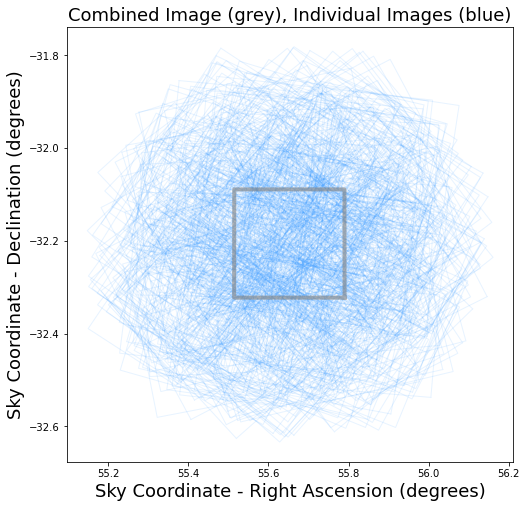

In [34]:
fig = plt.figure(figsize=(8,8))

for i in range(len(coadd_inputs_ccds_table)):    
    plt.plot( [corners_all_ccds[i][0][0], 
               corners_all_ccds[i][1][0], 
               corners_all_ccds[i][2][0], 
               corners_all_ccds[i][3][0], 
               corners_all_ccds[i][0][0]], 
              [corners_all_ccds[i][0][1], 
               corners_all_ccds[i][1][1], 
               corners_all_ccds[i][2][1], 
               corners_all_ccds[i][3][1],
               corners_all_ccds[i][0][1]],
              lw=1, alpha=0.1, color='dodgerblue' )

plt.plot( [corners_deepCoadd[0][0], 
           corners_deepCoadd[1][0], 
           corners_deepCoadd[2][0], 
           corners_deepCoadd[3][0], 
           corners_deepCoadd[0][0]], 
          [corners_deepCoadd[0][1], 
           corners_deepCoadd[1][1], 
           corners_deepCoadd[2][1], 
           corners_deepCoadd[3][1],
           corners_deepCoadd[0][1]],
          lw=4, alpha=0.6, color='grey' )

plt.xlabel( 'Sky Coordinate - Right Ascension (degrees)', fontsize=18 )
plt.ylabel( 'Sky Coordinate - Declination (degrees)', fontsize=18 )
# plt.xlim([])
# plt.ylim([])
plt.title( 'Combined Image (grey), Individual Images (blue)', fontsize=18 )
plt.savefig('corners')
plt.show()

## identify subset of calexps to combine

e.g., choose a date range of a few months and recreate

In [24]:
use_detector = coadd_inputs_ccds_table['ccd'][0]
use_visit = coadd_inputs_ccds_table['visit'][0]
calexp_meta = butler.get('calexp.metadata', detector=use_detector, visit=use_visit)
print( calexp_meta['FILTER'], calexp_meta['DATE-END'] )

i 2022-11-04T04:33:42.034


In [26]:
all_detectors = np.asarray( coadd_inputs_ccds_table['ccd'], dtype='int' )
all_visits = np.asarray( coadd_inputs_ccds_table['visit'], dtype='int' )

u_visits, ux = np.unique( all_visits, return_index = True )
u_dets = all_detectors[ux]

In [27]:
print(len(all_visits), len(u_visits))

571 161


In [28]:
# allmjds = np.zeros( len(u_visits), dtype='float' )
# for a in range(len(allmjds)):
#     calexp_meta = butler.get('calexp.metadata', detector=u_dets[a], visit=u_visits[a])
#     t = Time(calexp_meta['DATE-END'], format='isot', scale='utc')
#     allmjds[a] = t.mjd
#     del t

# fout = open('dates_all_ccds.dat', 'w')
# for a in range(len(allmjds)):
#     fout.write('%10.3f \n' % allmjds[a])
# fout.close()

In [30]:
allmjds = np.loadtxt( 'dates_all_ccds.dat', usecols=(0), dtype='float' )

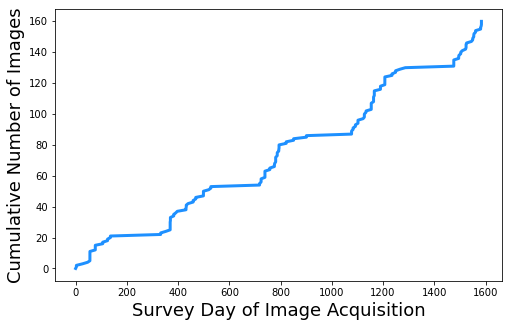

In [36]:
fig = plt.figure(figsize=(8,5))

sallmjds = np.sort(allmjds)
yaxis = np.arange( len(allmjds), dtype='int')

plt.plot( sallmjds-sallmjds[0], yaxis, ls='solid', lw=3, color='dodgerblue' )

plt.xlabel( 'Survey Day of Image Acquisition', fontsize=18 )
plt.ylabel( 'Cumulative Number of Images', fontsize=18 )
# plt.xlim([])
# plt.ylim([])
# plt.title( '', fontsize=18 )
plt.savefig('dates')
plt.show()

## recreate the coadd with the calexps

TBD